## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('The', 'DET'), ('Old', 'NOUN'), ('Guard', 'NOUN'), ("'s", 'PRT'), ('assault', 'NOUN'), ('on', 'ADP'), ('program', 'NOUN'), ('trading', 'NOUN'), ('and', 'CONJ'), ('its', 'PRON'), ('practitioners', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('fierce', 'ADJ'), ('and', 'CONJ'), ('broad-based', 'ADJ'), (',', '.'), ('in', 'ADP'), ('part', 'NOUN'), ('because', 'ADP'), ('some', 'DET'), ('Old', 'NOUN'), ('Guard', 'NOUN'), ('members', 'NOUN'), ('feel', 'VERB'), ('0', 'X'), ('their', 'PRON'), ('very', 'ADJ'), ('livelihood', 'NOUN'), ('is', 'VERB'), ('at', 'ADP'), ('stake', 'NOUN'), ('.', '.')], [('``', '.'), ('So', 'ADP'), ('the', 'DET'), ('focus', 'NOUN'), ('turned', 'VERB'), ('to', 'PRT'), ('other', 'ADJ'), ('fixed-income', 'ADJ'), ('markets', 'NOUN'), (',', '.'), ('corporate', 'ADJ'), ('and', 'CONJ'), ('mortgages', 'NOUN'), ('in', 'ADP'), ('particular', 'ADJ'), (',', '.'), ("''", '.'), ('she', 'PRON'), ('said', 'VERB'), ('*T*-1', 'X'), ('.', '.')], [('The', 'DET'), ('Bush', 'NOUN'

In [4]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
print(len(train_tagged_words))
print(len(test_tagged_words))

95622
5054


In [5]:
tokens = [pair[0] for pair in train_tagged_words]
print(len(tokens))

95622


In [6]:
# vocabulary
V = set(tokens)
print(len(V))


12078


In [7]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)
print(T)

{'DET', '.', 'X', 'ADJ', 'ADV', 'VERB', 'ADP', 'CONJ', 'PRON', 'PRT', 'NUM', 'NOUN'}


### Emission Probablilities

In [8]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [9]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probabilities

In [10]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [11]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [12]:
tags_matrix

array([[5.53949922e-03, 1.78227369e-02, 4.58815023e-02, 2.04961464e-01,
        1.24036605e-02, 3.92581895e-02, 9.51348711e-03, 4.81695577e-04,
        3.73314065e-03, 2.40847789e-04, 2.22784206e-02, 6.37885332e-01],
       [1.75139710e-01, 9.17613134e-02, 2.75824778e-02, 4.38976027e-02,
        5.25509268e-02, 8.86965916e-02, 9.10402015e-02, 5.79592586e-02,
        6.54407814e-02, 2.34360923e-03, 8.10347944e-02, 2.22462595e-01],
       [5.43772914e-02, 1.63610265e-01, 7.44697824e-02, 1.70626696e-02,
        2.63115931e-02, 2.05868289e-01, 1.44952953e-01, 1.02057084e-02,
        5.56530058e-02, 1.83224365e-01, 2.71089142e-03, 6.15531802e-02],
       [4.93339915e-03, 6.29830584e-02, 2.08847225e-02, 6.67653382e-02,
        4.27561253e-03, 1.21690510e-02, 7.74543658e-02, 1.71024501e-02,
        6.57786557e-04, 1.10179251e-02, 2.10491698e-02, 7.00707138e-01],
       [6.96666688e-02, 1.35333329e-01, 2.30000000e-02, 1.27666667e-01,
        8.06666687e-02, 3.45666677e-01, 1.17666669e-01, 7.00

In [13]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [14]:
tags_df

,DET,.,X,ADJ,ADV,VERB,ADP,CONJ,PRON,PRT,NUM,NOUN
DET,0.005539,0.017823,0.045882,0.204961,0.012404,0.039258,0.009513,0.000482,0.003733,0.000241,0.022278,0.637885
.,0.175140,0.091761,0.027582,0.043898,0.052551,0.088697,0.091040,0.057959,0.065441,0.002344,0.081035,0.222463
X,0.054377,0.163610,0.074470,0.017063,0.026312,0.205868,0.144953,0.010206,0.055653,0.183224,0.002711,0.061553
ADJ,0.004933,0.062983,0.020885,0.066765,0.004276,0.012169,0.077454,0.017102,0.000658,0.011018,0.021049,0.700707
ADV,0.069667,0.135333,0.023000,0.127667,0.080667,0.345667,0.117667,0.007000,0.015333,0.013333,0.032667,0.032000
VERB,0.134008,0.035720,0.217510,0.065292,0.081012,0.168327,0.091518,0.005525,0.035953,0.031751,0.023191,0.110195
ADP,0.324491,0.039949,0.034196,0.106743,0.013849,0.008309,0.016725,0.000746,0.067008,0.001491,0.062001,0.324491
CONJ,0.118826,0.035415,0.008388,0.118826,0.053122,0.157036,0.052190,0.000466,0.058248,0.005126,0.041473,0.350885
PRON,0.009660,0.041731,0.095440,0.074575,0.034003,0.479907,0.023570,0.005023,0.007728,0.012751,0.006955,0.208655
PRT,0.102034,0.042323,0.014108,0.085958,0.008858,0.399606,0.020013,0.002297,0.018701,0.001969,0.057743,0.246391


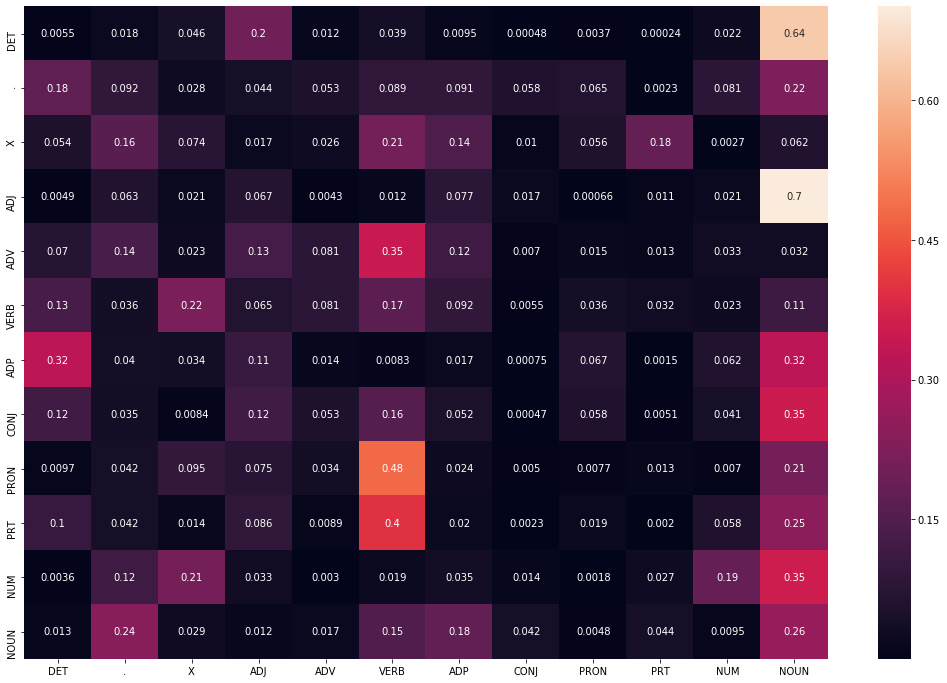

In [15]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df,annot=True)
plt.show()

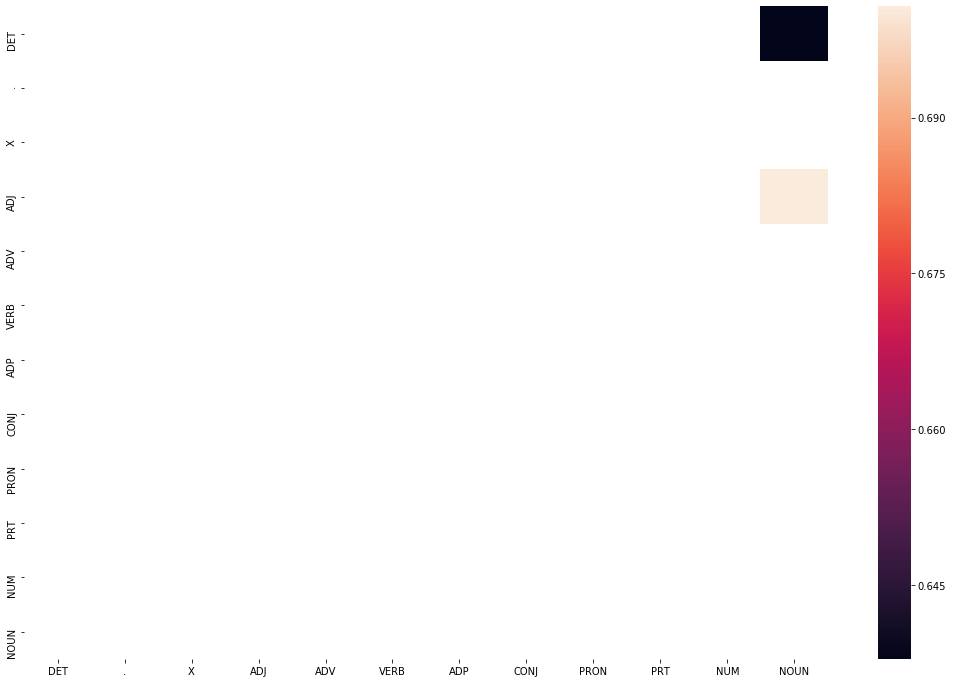

In [90]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Build the vanilla Viterbi based POS tagger

In [17]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [18]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]


In [19]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [20]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy_orig_viterbi = len(check)/len(tagged_seq)

In [21]:
accuracy_orig_viterbi


0.890625

In [22]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [23]:
incorrect_tagged_cases

[[('be', 'VERB'), (('delisted', 'DET'), ('delisted', 'VERB'))],
 [('the', 'DET'), (('close', 'ADJ'), ('close', 'NOUN'))],
 [('$', '.'), (('23.25', 'DET'), ('23.25', 'NUM'))],
 [(',', '.'), (('off', 'ADP'), ('off', 'ADV'))],
 [('in', 'ADP'), (('excess', 'ADJ'), ('excess', 'NOUN'))],
 [("''", '.'), (('FIRST', 'DET'), ('FIRST', 'NUM'))],
 [('FIRST', 'NUM'), (('CAMPAIGN', 'DET'), ('CAMPAIGN', 'NOUN'))]]

### Solve the problem of unknown words

1. Unigram Tagger

2. Unigram with RegExp Tagger

3. Original Viterbi Algorithm

4. Viterbi Algorithm Modification 1

5. Viterbi Algorithm Modification 2

## Unigram Tagger

In [47]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_accuracy=unigram_tagger.evaluate(test_set)
print(unigram_accuracy)

0.9070043529877325


In [68]:
  # Rules for Lexicon with unigram tagger
    
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense
    (r'.*es$', 'VERB'),               # 3rd singular present
    (r'.*ould$', 'MD'),              # modals
    (r'.*\'s$', 'PRON'),              # possessive nouns
    (r'.*s$', 'PRON'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN'),
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'),
    (r'.*able$', 'ADJ'),
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
    (r'.*ly$', 'ADV'),
    (r'\.$','.'), (r'\,$',','), (r'\?$','?'),
     (r'.*ould$', 'X'),
    (r'^(0|([*|-|$].*))','X')# fullstop, comm
]

## Unigram with RegExp Tagger

In [69]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

unigram_with_lexicon_accuracy=lexicon_tagger.evaluate(test_set)
print(unigram_with_lexicon_accuracy)

0.9410368025326474


## Viterbi Modification Technique 1

Use the transition probablilty when the emission probability is 0

In [74]:
def Viterbi_Unknown_Words(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [28]:
# tagging the test sentences
start = time.time()
tagged_seqo = Viterbi_Unknown_Words(test_tagged_words)
end = time.time()
difference = end-start

# accuracy
check = [i for i, j in zip(tagged_seqo, test_run_base) if i == j] 
accuracy_viterbi_modified_1 = len(check)/len(tagged_seq)

In [29]:
accuracy_viterbi_modified_1


0.90625

In [30]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [31]:
incorrect_tagged_cases

[[('be', 'VERB'), (('delisted', 'DET'), ('delisted', 'VERB'))],
 [('the', 'DET'), (('close', 'ADJ'), ('close', 'NOUN'))],
 [('$', '.'), (('23.25', 'DET'), ('23.25', 'NUM'))],
 [(',', '.'), (('off', 'ADP'), ('off', 'ADV'))],
 [('in', 'ADP'), (('excess', 'ADJ'), ('excess', 'NOUN'))],
 [("''", '.'), (('FIRST', 'DET'), ('FIRST', 'NUM'))],
 [('FIRST', 'NUM'), (('CAMPAIGN', 'DET'), ('CAMPAIGN', 'NOUN'))]]

In [91]:
# specify patterns for tagging
#Use Regexp along with Bigram Tagger
def bigram_tagger(word,train_set=train_set):
    
    
    patterns = [
     (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),
            (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
 
]
    regexpd_tagger = nltk.RegexpTagger(patterns)
    regexp_bigram_tag=nltk.BigramTagger(train_set,backoff=regexpd_tagger)
    return regexp_bigram_tag.tag_sents([[(word)]])

## Viterbi Modification Technique 2

In [92]:
# Use Viterbi with bigram tagger for unknown words

def Viterbi_bigram_Tagger(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        
        # unknown words from bigram taggr
        if word not in V:
            
            unknown_word=bigram_tagger(word)
            for sent in unknown_word:
                
                for tup in sent:
                    
                    state.append(tup[1])
        else:
            
            p = [] 
            for tag in T:
                
                
                
                
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                    
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

In [71]:
# tagging the test sentences
start = time.time()

tagged_seq = Viterbi_bigram_Tagger(test_tagged_words)
end = time.time()
difference = end-start


#### Evaluating tagging accuracy

In [72]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy_viterbi_modified_2 = len(check)/len(tagged_seq)

In [73]:
accuracy_viterbi_modified_2


0.9375

In [41]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [42]:
incorrect_tagged_cases

[[('the', 'DET'), (('close', 'ADJ'), ('close', 'NOUN'))],
 [(',', '.'), (('off', 'ADP'), ('off', 'ADV'))],
 [('in', 'ADP'), (('excess', 'ADJ'), ('excess', 'NOUN'))],
 [("''", '.'), (('FIRST', 'NOUN'), ('FIRST', 'NUM'))]]

In [43]:
sentence_test = 'Android is a mobile operating system developed by Google.'
words = word_tokenize(sentence_test)


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [58]:
acccuracy_of_techniques = [['Original Viterbi', accuracy_orig_viterbi * 100], 
                  ['Viterbi Modification Technique 1', accuracy_viterbi_modified_1 * 100], 
                  ['Unigram Tagger', unigram_accuracy * 100],
                  ['Unigram with RegexpTagger', unigram_with_lexicon_accuracy * 100],
                  ['Viterbi with Bigram Tagger combined', accuracy_viterbi_modified_2 * 100]]

In [59]:
Comparison_of_Techniques = pd.DataFrame(acccuracy_of_techniques, columns = ['Technique', 'Accuracy'])

Comparison_of_Techniques.set_index('Technique', drop = True, inplace = True)

In [60]:
Comparison_of_Techniques.sort_values(by='Accuracy',ascending=False,inplace=True)
Comparison_of_Techniques

,Accuracy
Technique,
Unigram with RegexpTagger,94.103680
Viterbi with Bigram Tagger combined,93.750000
Unigram Tagger,90.700435
Viterbi Modification Technique 1,90.625000
Original Viterbi,89.062500


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [61]:
sentence_test = 'Android is a mobile operating system developed by Google.'
words = word_tokenize(sentence_test)

In [62]:
start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [63]:
print(tagged_seq)


[('Android', 'DET'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.')]


In [65]:
start = time.time()
tagged_seq1 = Viterbi_bigram_Tagger(words)
end = time.time()
difference = end-start

###### As we can see above the original Viterbi tagged the words Android and Google as Determinant where as the modified Viterbi along with Bigram tagger has correctly tagged the words

In [66]:
print(tagged_seq1)


[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


In [75]:
test2='The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.'
words2 = word_tokenize(test2)

In [79]:
start = time.time()
tagged_seq2 = Viterbi(words2)
end = time.time()
difference = end-start

In [80]:
print(tagged_seq2)

[('The', 'DET'), ('2018', 'DET'), ('FIFA', 'DET'), ('World', 'NOUN'), ('Cup', 'DET'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'DET'), ('FIFA', 'DET'), ('World', 'NOUN'), ('Cup', 'DET'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'DET'), ('contested', 'DET'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


In [81]:
start = time.time()
tagged_seq2 = Viterbi_bigram_Tagger(words2)
end = time.time()
difference = end-start

###### As we can see above the original Viterbi tagged the words FIFA and 2018 as Determinant where as the modified Viterbi along with Bigram tagger has correctly tagged the words

In [82]:
print(tagged_seq2)

[('The', 'DET'), ('2018', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'VERB'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


In [83]:
test3='NASA invited social media users to experience the launch of ICESAT-2 Satellite.'
words3 = word_tokenize(test3)

In [85]:
start = time.time()
tagged_seq3 = Viterbi(words3)
end = time.time()
difference = end-start

In [86]:
print(tagged_seq3)

[('NASA', 'DET'), ('invited', 'DET'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'DET'), ('Satellite', 'DET'), ('.', '.')]


In [87]:
start = time.time()
tagged_seq3 = Viterbi_bigram_Tagger(words3)
end = time.time()
difference = end-start

###### As we can see above the original Viterbi tagged the words ICESAT-2 and Satellite as Determinant where as the modified Viterbi along with Bigram tagger has correctly tagged the words

In [89]:
print(tagged_seq3)

[('NASA', 'NOUN'), ('invited', 'VERB'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'NOUN'), ('Satellite', 'NOUN'), ('.', '.')]
